In [1]:
######################
##	Library Imports
######################
%matplotlib inline
import matplotlib as mpl
# mpl.use('TkAgg') # Use this backend for displaying plots in window
# mpl.use('Agg') # Use this backend for writing plots to file

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize']    = [16, 9]
# mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex']       = True
mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.size']         = 22
mpl.rcParams['font.serif']        = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth']   = 1.25
mpl.rcParams['lines.markersize']  = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
from scipy.linalg import subspace_angles
np.set_printoptions(threshold=sys.maxsize)
from numba import njit, jit, prange

In [2]:
mpl.get_backend()

'module://ipykernel.pylab.backend_inline'

In [82]:
@njit    #njit(warn = False)
def compute_zdata(clv, a_k, num_tsteps, dof, numLEs):
    
    z_data       = np.zeros((dof, dof))
    z_data_proj  = np.zeros((dof, dof))
    z_data_wnorm = np.zeros((dof, dof))
    v            = np.zeros((num_tsteps, dof, dof))
    v_wnorm      = np.zeros((num_tsteps, dof, dof))
    
    v_avg = np.zeros((num_tsteps, ))
    v_c   = 0.0

    K           = np.arange(2.0, float(dof + 2), 1.0)
    K_norm_sqr  = np.linalg.norm(K) ** 2
    K_wnorm_sqr = np.linalg.norm(K * a_k[2:]) ** 2
    
    for t in range(num_tsteps):
        
        v_avg[t] = np.square(np.dot(clv[t, :, 0], K)) / (K_norm_sqr)
        
        for j in range(numLEs):
            z_data[:, j] += np.square(clv[t, :, j])
            
            

            v[t, :, j]       = clv[t, :, j] - (K * (np.dot(clv[t, :, j], K))) / (K_norm_sqr)
            v_wnorm[t, :, j] = (clv[t, :, j] * a_k[2:]) - ((K * a_k[2:]) * (np.dot(clv[t, :, j] * a_k[2:], K * a_k[2:]))) / (K_wnorm_sqr)
            
            v[t, :, j]       = v[t, :, j] / np.linalg.norm(v[t, :, j])
            v_wnorm[t, :, j] = v_wnorm[t, :, j] / np.linalg.norm(v_wnorm[t, :, j])
            
            z_data_proj[:, j]  += np.square(v[t, :, j])
            z_data_wnorm[:, j] += np.square(v_wnorm[t, :, j])
            
            
#         v += (np.dot(clv[t, :, 0], K) / (K_norm_sqr)) * (z_data_proj[:, 0])
    
    z_data       = z_data / num_tsteps
    z_data_proj  = z_data_proj / num_tsteps
    z_data_wnorm = z_data_wnorm / num_tsteps
    
    

    return z_data, z_data_proj, z_data_wnorm, v_avg

In [4]:
def open_file(N, k0, a, beta, u0, iters, m_end, m_iter, trans, numLEs, func_type):


    ## Check if file exists and open
    if numLEs == 1:
        ## Create filename from data
        filename = input_dir + "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]/LCEData_ITERS[{},{},{}]".format(N, k0, a, beta, u0, iters, m_end, m_iter)

        ## Check if file exists and open
        if os.path.exists(filename + "_TRANS[{}]_LEs[{}].h5".format(trans, numLEs)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]_LEs[{}].h5".format(trans, numLEs), 'r')
        elif os.path.exists(filename + "_TRANS[{}]_LEs[{}].h5".format(trans * 10, numLEs)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]_LEs[{}].h5".format(trans * 10, numLEs), 'r')
        elif os.path.exists(filename + "_TRANS[{}]_LEs[{}].h5".format(trans * 100, numLEs)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]_LEs[{}].h5".format(trans * 100, numLEs), 'r')
        elif os.path.exists(filename + "_TRANS[{}]_LEs[{}].h5".format(trans / 100, numLEs)):
            HDFfileData = h5py.File(filename + "_TRANS[{}]_LEs[{}].h5".format(trans, numLEs), 'r')
        else: 
            print("File doesn't exist, check parameters!")
            sys.exit()		
    else:
        ## Create filename from data
        filename = input_dir + "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]/CLVData_ITERS[{},{},{}]".format(N, k0, a, beta, u0, iters, m_end, m_iter)

        if os.path.exists(filename + "_TRANS[{}].h5".format(trans)):
            HDFfileData = h5py.File(filename + "_TRANS[{}].h5".format(trans), 'r')
        elif os.path.exists(filename + "_TRANS[{}].h5".format(trans * 10)):
            HDFfileData = h5py.File(filename + "_TRANS[{}].h5".format(trans * 10), 'r')
        elif os.path.exists(filename + "_TRANS[{}].h5".format(trans / 10)):
            HDFfileData = h5py.File(filename + "_TRANS[{}].h5".format(trans / 10), 'r')
        elif os.path.exists(filename + "_TRANS[{}].h5".format(trans * 100)):
            HDFfileData = h5py.File(filename + "_TRANS[{}].h5".format(trans * 100), 'r')
        else: 
            print("File doesn't exist, check parameters!")
            sys.exit()


    return HDFfileData


In [94]:
k0     = 1
# alpha  = np.arange(0.00, 3.5, 0.05)
# alpha  = np.array([0.0, 0.05, 0.1, 0.15, 0.2, 3.30, 3.35, 3.40, 3.45])
# alpha  = np.array([3.30, 3.35, 3.40, 3.45])
alpha = np.array([0.5])#np.arange(3.0, 3.5, 0.05)
beta   = 0.0
iters  = 400000
trans  = 1000
N      = 512
u0     = "RANDOM"
m_end  = 8000
m_iter = 50
dof    = int(N /2  - k0)

numLEs = int(N / 2 - k0)
    
func_type = "all"

input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS"
output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/CLV"

In [95]:
vec           = np.zeros((dof, alpha.shape[0]))
wnorm_vec     = np.zeros((dof, alpha.shape[0]))
projected_vec = np.zeros((dof, alpha.shape[0]))
v_const       = np.zeros((alpha.shape[0], ))

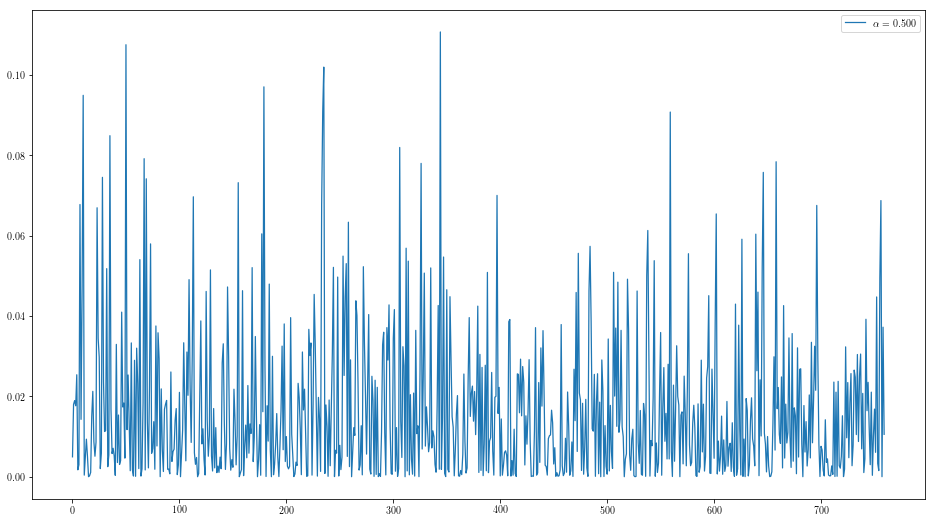

In [96]:
plt.figure(figsize = (16, 9), tight_layout = False)
for i, a in enumerate(alpha):

    ## ------- Read in Data
    HDFfileData = open_file(N, k0, a, beta, u0, iters, m_end, m_iter, trans, numLEs, func_type)

    ## --------- Get System Parameters
    amps    = HDFfileData['Amps'][:]
    kmin    = k0 + 1
    num_osc = amps.shape[0];
    

    ## --------- Read in CLV Data
    if numLEs == 1:
        CLVs          = HDFfileData['LargestCLV'][:]
        CLV           = np.reshape(CLVs, (dof, 1))
        num_clv_steps = 0
    else:
        ## Read in data
        CLVs          = HDFfileData['CLVs']
        num_clv_steps = CLVs.shape[0]

        ## Reshape the CLV and Angles data
        clv_dims = CLVs.attrs['CLV_Dims']
        CLV      = np.reshape(CLVs, (CLVs.shape[0], dof, dof))

    ## --------- Compute time averaged squared vector components
    zdata, zdata_proj, zdata_wnorm, v_c = compute_zdata(CLV, amps, num_clv_steps, dof, numLEs)

    ## --------- Collect data
    vec[:, i] = zdata[:, 0] 
    wnorm_vec[:, i] = zdata_wnorm[:, 0]
    projected_vec[:, i] = zdata_proj[:, 0] 
    
    

    plt.plot(v_c)

plt.legend([r"$\alpha = {:0.3f}$".format(a) for a in alpha])
plt.show()

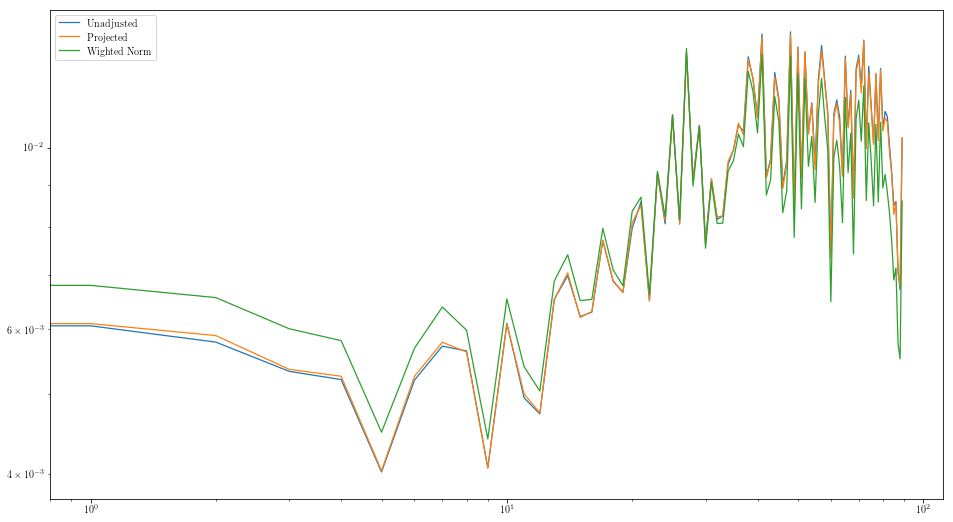

In [97]:
fig1 = plt.figure(figsize = (16, 9), tight_layout = False)
gs1  = GridSpec(1, 1)

ax1 = fig1.add_subplot(gs1[0, 0])

ax1.plot(vec[-90:, 0])
ax1.plot(projected_vec[-90:, 0])
ax1.plot(wnorm_vec[-90:, 0] )
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend([r'Unadjusted', r'Projected', r'Wighted Norm'])

plt.show()

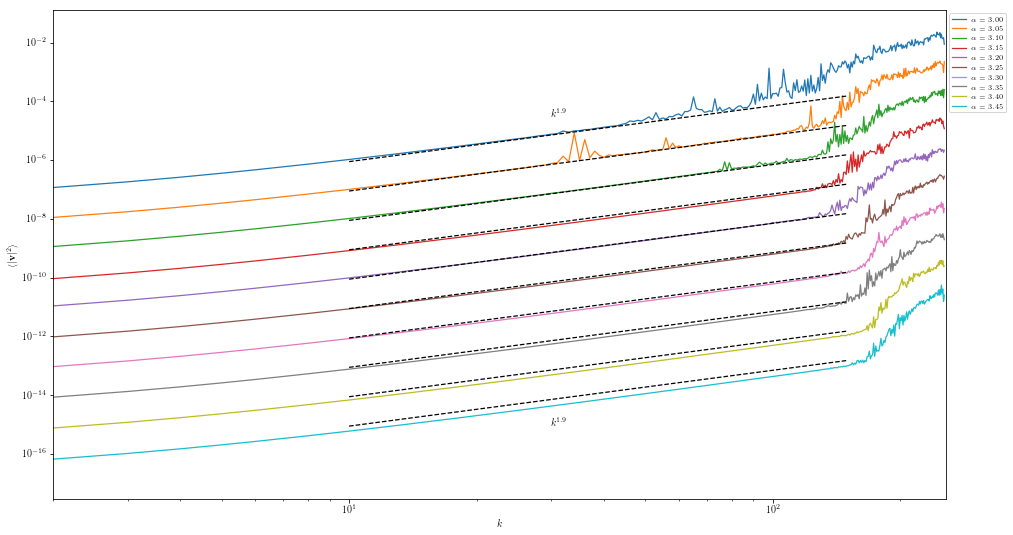

In [21]:
fig1 = plt.figure(figsize = (16, 9), tight_layout = False)
gs1  = GridSpec(1, 1)

ax1 = fig1.add_subplot(gs1[0, 0])

## Plot data
for i in range(alpha.shape[0]):
    ax1.plot(projected_vec[:, i] / 10**i)
    
## Plot scaling
exp_mid = 1.9
C_mid = 7.95
kx_mid = np.arange(10, 150)
for i in range(alpha.shape[0]):
    ax1.plot(kx_mid, kx_mid ** exp_mid / 10 ** (C_mid + i) , 'k--')

ax1.set_xticks(np.arange(0, dof, 6))
ax1.set_xticklabels(np.arange(kmin, num_osc, 6))
ax1.set_yscale('log')
ax1.set_xscale('log')
# ax1.set_yticks([])
# ax1.set_yticklabels([])
ax1.set_xlim(kmin, num_osc - 1)
ax1.set_xlabel(r"$k$")
ax1.set_ylabel(r"$\langle |\mathbf{v}|^2\rangle$")
x = [r"$\alpha = {:0.2f}$".format(a) for a in alpha]
# x.append(r"$k = {}$".format(exp_mid))
ax1.legend(x, bbox_to_anchor = (1.0, 1.0), loc = "upper left", fontsize = 'x-small')
ax1.text(30, 1/10**4.5, r"$k^{{{}}}$".format(exp_mid))
ax1.text(30, 1/10**15, r"$k^{{{}}}$".format(exp_mid))

plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/CLVs" + "/LargeAlpha_Scaling_N[{}].pdf".format(N))
plt.show()

In [22]:
alpha = np.arange(0.0, 0.75, 0.05)
projected_vec = np.zeros((dof, alpha.shape[0]))

for i, a in enumerate(alpha):

    ## ------- Read in Data
    HDFfileData = open_file(N, k0, a, beta, u0, iters, m_end, m_iter, trans, numLEs, func_type)

    ## --------- Get System Parameters
    amps    = HDFfileData['Amps'][:]
    kmin    = k0 + 1
    num_osc = amps.shape[0];
    dof     = num_osc - kmin

    ## --------- Read in CLV Data
    if numLEs == 1:
        CLVs          = HDFfileData['LargestCLV'][:]
        CLV           = np.reshape(CLVs, (dof, 1))
        num_clv_steps = 0
    else:
        ## Read in data
        CLVs          = HDFfileData['CLVs']
        num_clv_steps = CLVs.shape[0]

        ## Reshape the CLV and Angles data
        clv_dims = CLVs.attrs['CLV_Dims']
        CLV      = np.reshape(CLVs, (CLVs.shape[0], dof, dof))

    ## --------- Compute time averaged squared vector components
    zdata, zdata_proj, zdata_wnorm = compute_zdata(CLV, amps, num_clv_steps, dof, numLEs)

    ## --------- Collect data
    vec[:, i] = zdata[:, 0] 
    wnorm_vec[:, i] = zdata_wnorm[:, 0]
    projected_vec[:, i] = zdata_proj[:, 0] 
    
    plt.plot(v_c)

plt.legend([r"$\alpha = {:0.3f}$".format(a) for a in alpha])
plt.show()

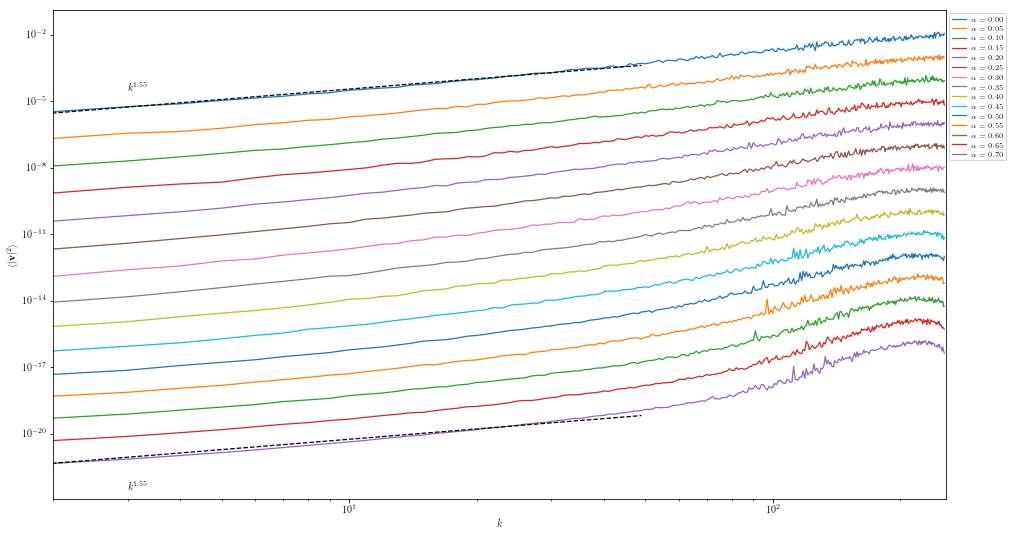

In [23]:
fig1 = plt.figure(figsize = (16, 9), tight_layout = False)
gs1  = GridSpec(1, 1)

ax1 = fig1.add_subplot(gs1[0, 0])

## Plot data
for i in range(alpha.shape[0]):
    ax1.plot(projected_vec[:, i] / 10**i)
    
## Plot scaling
exp_mid = 1.55
C_mid = 6
kx_mid = np.arange(1, 50)
# for i in range(alpha.shape[0]):
ax1.plot(kx_mid, kx_mid ** exp_mid / 10 ** (C_mid + 0) , 'k--')

exp_mid = 1.55
C_mid = 21.8
kx_mid = np.arange(1, 50)
# for i in range(alpha.shape[0]):
ax1.plot(kx_mid, kx_mid ** exp_mid / 10 ** (C_mid + 0) , 'k--')

ax1.set_xticks(np.arange(0, dof, 6))
ax1.set_xticklabels(np.arange(kmin, num_osc, 6))
ax1.set_yscale('log')
ax1.set_xscale('log')
# ax1.set_yticks([])
# ax1.set_yticklabels([])
ax1.set_xlim(kmin, num_osc - 1)
ax1.set_xlabel(r"$k$")
ax1.set_ylabel(r"$\langle |\mathbf{v}|^2\rangle$")
x = [r"$\alpha = {:0.2f}$".format(a) for a in alpha]
# x.append(r"$k = {}$".format(exp_mid))
ax1.legend(x, bbox_to_anchor = (1.0, 1.0), loc = "upper left", fontsize = 'x-small')
ax1.text(3, 1/10**4.5, r"$k^{{{}}}$".format(exp_mid))
ax1.text(3, 1/10**22.5, r"$k^{{{}}}$".format(exp_mid))

# plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/CLVs" + "/SmallAlpha_Scaling_N[{}].pdf".format(N))
plt.show()